In [23]:
import wandb
from wandb.keras import WandbCallback
from emojihunt import *
import tensorflow as tf
import keras
from keras import callbacks
from keras.models import Sequential, load_model
from keras.layers import Activation, LeakyReLU, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate, UpSampling2D, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
import json
import os
from skimage.segmentation import slic, mark_boundaries, clear_border
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs: 0


Create our own emojihunt object that returns a segmentation mask with each image

In [43]:
class SegEmojiHunt(EmojiHunt):
    def generate_image_and_points(self):
        '''
        Returns a target image, emoji example (uncorrupted), and ground truth gt_points. For your testing and development
        '''
        emoji_target = self.get_random_emoji_img()
        test_image   = self.get_background()

        gt_points = []
        mask = np.zeros(test_image.shape[:-1], dtype=bool)

        for _ in range(random.randint(1,10)):
            x = random.randint(0,512-self.emoji_size-1)
            y = random.randint(0,512-self.emoji_size-1)
            gt_points.append((x+self.emoji_size//2,y+self.emoji_size//2))
            augmented_emoji = self.augment_emoji(emoji_target)
            emoji_mask = np.sum(augmented_emoji,axis=-1) > 25
            # Mark the edges of the mask
            

            test_image[x:x+self.emoji_size,y:y+self.emoji_size] = np.where(
                np.expand_dims(np.sum(augmented_emoji,axis=-1) > 25,-1), augmented_emoji, test_image[x:x+self.emoji_size,y:y+self.emoji_size])
            mask[x:x+self.emoji_size,y:y+self.emoji_size] = emoji_mask
        
        test_image_agus = [iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
                            iaa.GaussianBlur(sigma=(0.0, 0.25))]

        test_image = iaa.Sequential(test_image_agus)(image=test_image)

        return test_image, emoji_target, gt_points, mask

SyntaxError: invalid syntax (3227913519.py, line 19)

Basic hyperparameters

In [25]:
batch_size = 8
lr = 0.0001
img_width = img_height = 256

if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


Data Generator to feed the model. Resizes the input image, converts it to LAB, and normalizes it to [-1, 1]

In [26]:
class DataGenerator(keras.utils.Sequence):
    emoji_hunt_object = SegEmojiHunt()

    def __init__(self, batch_size, augment, num_batches=100):
        self.batch_size = batch_size
        self.augment = augment
        self.num_batches = num_batches
        self.datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

    def __len__(self):
        return batch_size*self.num_batches

    def __getitem__(self, idx):
        'Generate one batch of data'
        X = np.empty((self.batch_size, *input_shape), dtype=np.uint8)
        # Y = np.zeros((self.batch_size, 20), dtype=np.float16) # We can have up to 10 emojis, each with an xy coordinate
        Y = np.zeros((self.batch_size, img_width, img_height), dtype=np.uint8)
        for i in range(self.batch_size):
            target_image, emoji, ground_truth, mask = self.emoji_hunt_object.generate_image_and_points()
            # Convert to RGB and resize
            target_image = cv2.resize(target_image, (img_width, img_height), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask.astype('uint8'), (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2LAB)

            X[i,] = target_image
            Y[i] = mask

        # Normalize
        self.datagen.standardize(X)
        assert img_width == img_height
        

        return X, Y

Generate some example masks

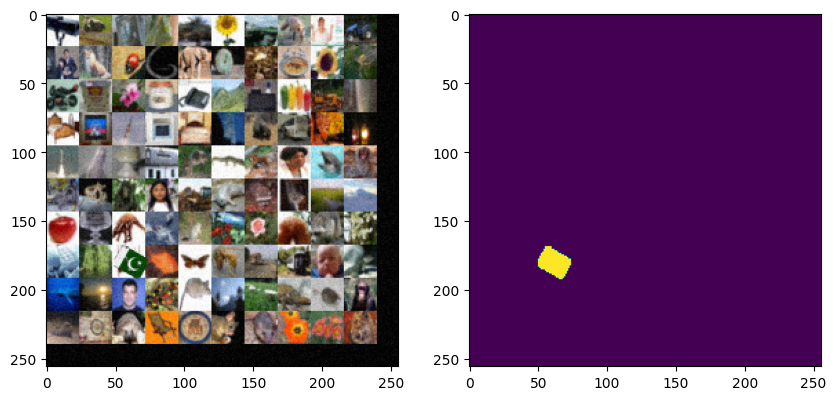

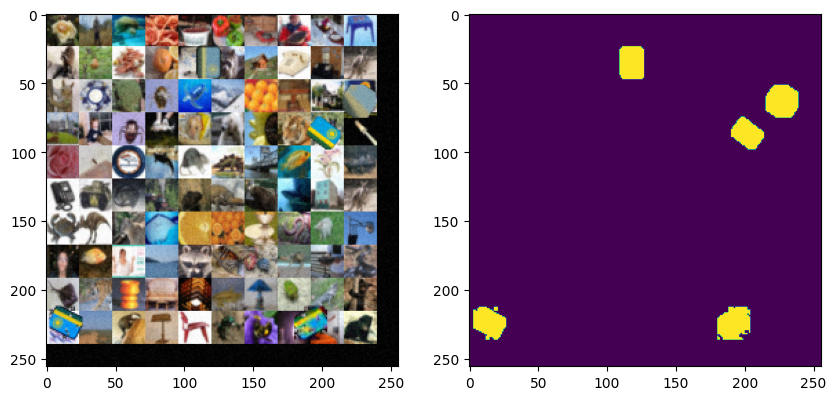

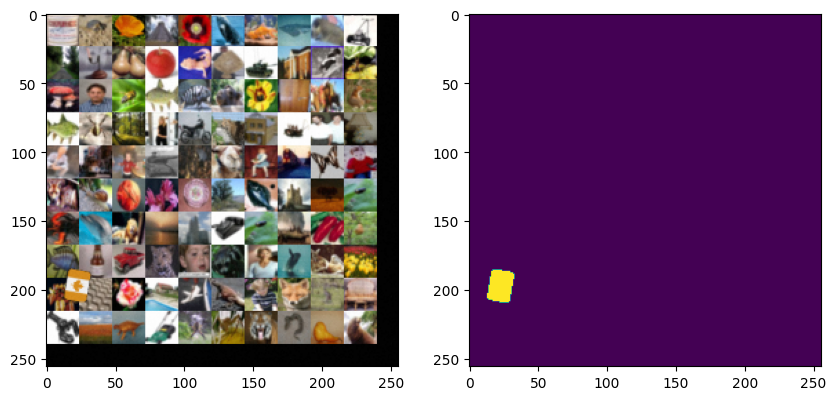

In [27]:
train_ds = DataGenerator(batch_size, augment=False, num_batches=150)
val_ds = DataGenerator(batch_size, augment=False, num_batches=20) # Only used for scoring, not super useful

batch = train_ds[0]
for i in range(3):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(batch[0][i], cv2.COLOR_LAB2RGB))
    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    plt.imshow(batch[1][i])
    plt.show()

Setup for weights and biases logging (optional)

In [28]:
wandb.init(
    # set the wandb project where this run will be logged
    project="emoji-hunt",

    # track hyperparameters and run metadata with wandb.config
    config={
        "batch_size": batch_size
    }
)

# def wandb_point_and_mask(image, pred_point, true_point, pred_mask, true_mask):
#     return wandb.Image(image, boxes={
#         "predictions": {
#             "box_data": [{
#                 "position": {
#                     "minX": pred_point[0],
#                     "maxX": pred_point[0],
#                     "minY": pred_point[1],
#                     "maxY": pred_point[1]
#                     },
#             }],
#         },
#         "ground_truth": {
#             "box_data": [{
#                 "position": {
#                     "minX": true_point[0],
#                     "maxX": true_point[0],
#                     "minY": true_point[1],
#                     "maxY": true_point[1]
#                     },
#             }],
#         }
#     },
#     masks={
#         "predictions": {
#             "mask_data": pred_mask
#         },
#         "ground_truth": {
#             "mask_data": true_mask
#         }
#     })

# class PointMaskLogger(tf.keras.callbacks.Callback):
#     def __init__(self):
#         super(PointMaskLogger, self).__init__()
#         self.val_images, mask_and_point = next(iter(val_ds))
#         self.true_maskss = mask_and_point[0]
#         self.true_points = []
#         for j, (x,y) in enumerate(mask_and_point[1]):
#             self.true_points.append((x, y))


#     def on_epoch_end(self, logs, epoch):
#         localization_list = []

#         for idx in range(len(self.val_images)):
#             # get image
#             image = self.val_images[idx]
#             # get ground truth mask and point coordinates.
#             true_mask = int(self.true_masks[idx].numpy())
#             true_point = self.true_points[idx]
#             # get model prediction.
#             pred_label, p_bbox = model.predict(np.expand_dims(image, 0))
#             # get argmax of the prediction
#             pred_label = int(np.argmax(pred_label[0])) 
#             # get wandb image
#             localization_list.append(wandb_bbox(image, 
#                                                 p_bbox[0].tolist(),
#                                                 pred_label, 
#                                                 t_bbox.numpy().tolist(), 
#                                                 true_label, 
#                                                 class_id_to_label))


#         wandb.log({"predictions" : localization_list})



https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ for the U-Net architecture

In [29]:
def double_conv_block(x, n_filters):
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D()(f)
   p = Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = Concatenate(axis=-1)([x, conv_features])
   x = Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [30]:
if os.path.exists('model.h5'):
    model = load_model('model.h5')
else:
    in1 = keras.Input(shape=input_shape)

    # encoder: contracting path - downsample
    f1, p1 = downsample_block(in1, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    # outputs
    output_mask = Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    model = keras.Model(in1, output_mask, name="U-Net")

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics='acc')
    
    model.summary()

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True, start_from_epoch=5)
tensorboard = callbacks.TensorBoard(log_dir=f'./logs/run{np.random.randint(1,1000)}', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=5)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000001, min_delta=0.0003)
checkpoint = callbacks.ModelCheckpoint(f'./model.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
model.fit(train_ds,
        batch_size=batch_size,
        epochs=70,
        callbacks=[early_stopping, reduce_lr, checkpoint, WandbCallback(input_type="image", log_weights=True, save_model=True)],
        # callbacks=[early_stopping, reduce_lr, checkpoint],
        use_multiprocessing=True,
        workers=90)

## Results
GlobalAveragePooling2D() -> 64 -> 32: Loss of ~15000 after 10 epochs  
GlobalAveragePooling2D() -> 128 -> 128: Loss of ~14800 after 16 epochs
Conv2D(32, (3, 3), 'relu') -> Conv2D(32, (3, 3), 'relu') -> Pool(2,2) -> Conv2D(64, (3, 3), 'relu') -> Conv2D(64, (3, 3), 'relu') -> Flatten() -> 256 -> 128: Loss of ~11000 after 15 epochs

# Some Visualizations

1/1 [==============================] - 1s 748ms/step


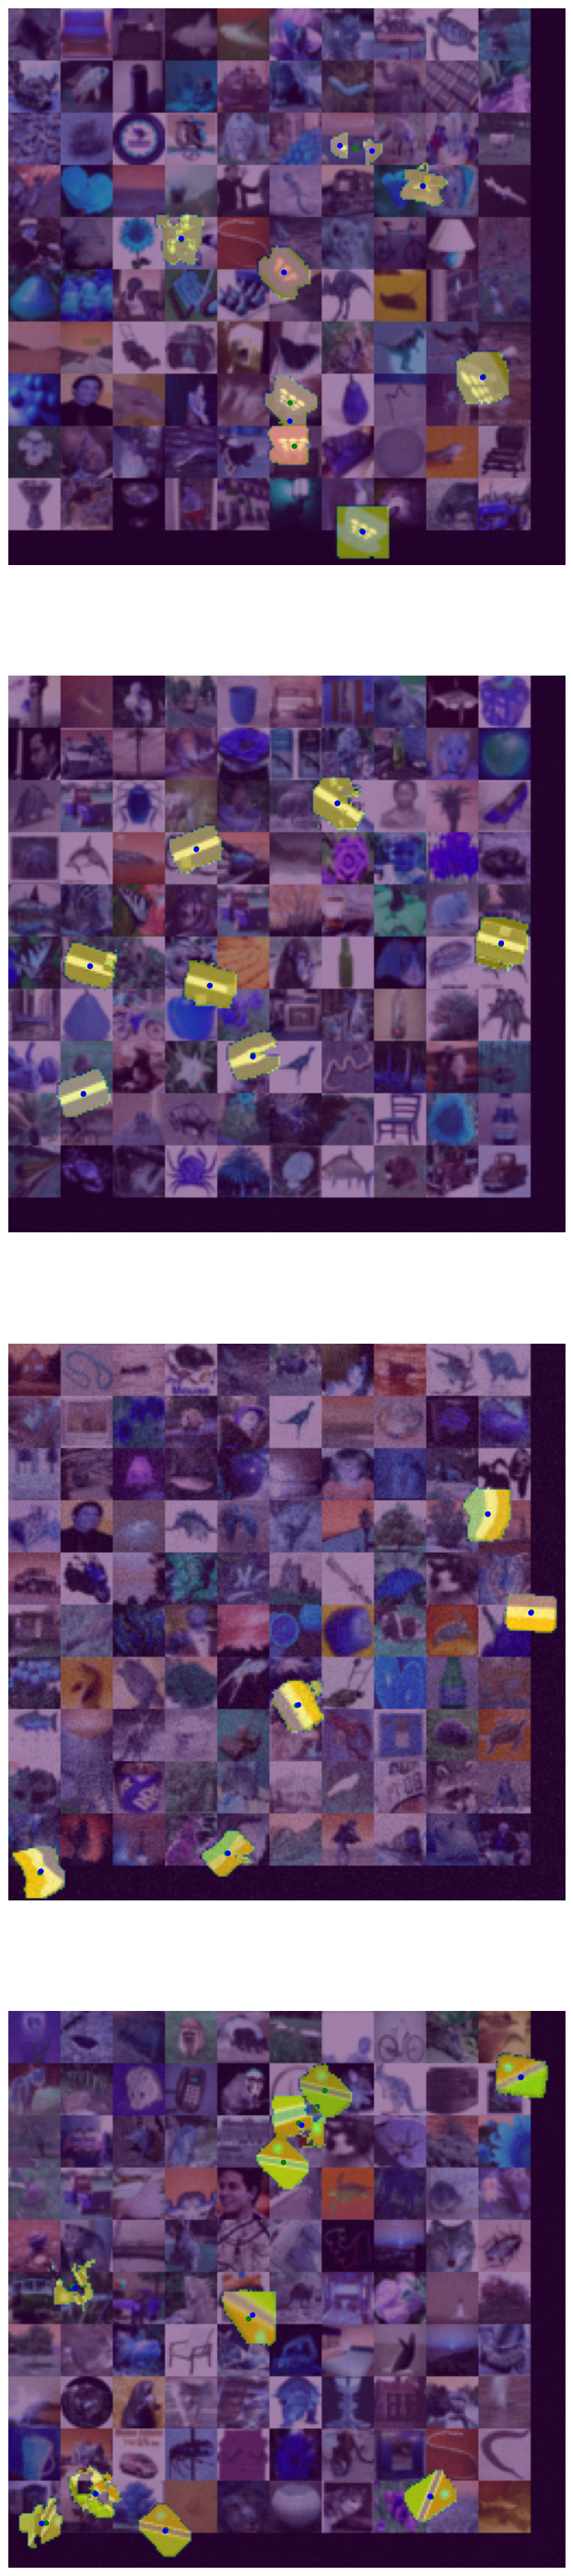

In [36]:
samples = [val_ds.emoji_hunt_object.generate_image_and_points() for _ in range(batch_size//2)]

sample_imgs = [sample[0] for sample in samples]
sample_emojis = [sample[1] for sample in samples]
sample_ground_truth = [sample[2] for sample in samples]

inputs = np.empty((batch_size//2, *input_shape))
for i, image in enumerate(sample_imgs):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    sample_imgs[i] = image # For displaying in human-viewable form
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    inputs[i] = image

preds = model.predict(inputs, batch_size=batch_size//2)
pred_masks = np.argmax(preds, axis=-1)
pred_coords = preds[1]
# Plot 4 results, print the image and mask seperately
fig, axs = plt.subplots(4, 1, figsize=(30, 40))
for i, (img, pred, emoji) in enumerate(zip(sample_imgs, pred_masks, sample_emojis)):
    if i >= 4:
        break
    ax = axs[i]
    ax.imshow(img)
    ax.imshow(pred, alpha=0.5)
    ax.axis('off')
    for y, x in sample_ground_truth[i]:
         ax.add_patch(plt.Circle((x//2, y//2), 1, color='g', fill=True))

    segments = regionprops(label(pred_masks[i]))
    ret_coords = []
    for props in segments:
        if props.area < 20:
            continue
        cx, cy = props.centroid  # centroid coordinates
        v = props.label
        # print(f'Emoji {v} at ({cx}, {cy})')
        ax.add_patch(plt.Circle((cy, cx), 1, color='b', fill=True))


# Score the model

In [42]:
# TODO: IOU metric
def test_good_function(image, _):
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    val_ds.datagen.standardize(image)
    preds = model.predict(np.array([image]), batch_size=1, verbose=0)
    pred_masks = np.argmax(preds, axis=-1)

    # Cluster regions of 1s
    segments = regionprops(label(pred_masks[0]))
    ret_coords = []
    for props in segments:
        if props.area < 20:
            continue
        cx, cy = props.centroid  # centroid coordinates
        v = props.label
        # print(f'Emoji {v} at ({cx}, {cy})')
        ret_coords.append((int(cx*2), int(cy*2)))

    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax.imshow(pred_masks[0])
    return ret_coords

# test_good_function(*val_ds.emoji_hunt_object.generate_image_and_points())
emoji_hunt_object = EmojiHunt() 
config = emoji_hunt_object.get_config()
config['emoji_transforms']['DirectedEdgeDetect'] = False
config['emoji_transforms']['ChangeColorTemperature'] = False
config['emoji_transforms']['PiecewiseAffine'] = False
emoji_hunt_object.update_config(config)
emoji_hunt_object.offical_test(test_good_function,emoji_hunt_object.get_config())
    

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
     Grayscale
     SigmoidContrast
     CLAHE
     Emboss
     Fliplr
     PerspectiveTransform
     WithPolarWarping
     Rot90
     ElasticTransformation
     Jigsaw
Scores (lower is better)....
    Run 0 -> 6.708203932499369
    Run 1 -> 1.3440825170409967
    Run 2 -> 75.18641406220254
    Run 3 -> 148.21158688113806
    Run 4 -> 1.618033988749895
    Run 5 -> 104.25116656306736
    Run 6 -> 118.17307065677748
    Run 7 -> 67.58171110852572
    Run 8 -> 1.5500938466242948
    Run 9 -> 60.05408182830021
    Run 10 -> 6.082762530298219
    Run 11 -> 1.4135562914111457
    Run 12 -> 3.8201770719265133
    Run 13 -> 3.3741391649574886
    Run 14 -> 2.3409960962920566
    Run 15 -> 1.5785844453984341
    Run 16 -> 2.3561860253506937